**Overview**

*   Structured outputs are used when models need to respond with a specific output structure, which is useful for tasks like storing model output in a database.
*   This contrasts with standard chatbot applications where models respond directly in natural language.
*   The goal is to have models respond in a structured format that conforms to a predefined schema.

**Key Concepts**

*   **Schema Definition**: The output structure is defined as a schema using a variety of formats.
*   **Returning Structured Output**: Models are instructed to return output that matches the schema.
*   LangChain provides a `with_structured_output()` method that automates the process of binding the schema to the model and parsing the output.

**Schema Definition**

*   The output structure is represented in a format that can be understood by both the user and the model.
*   Common formats include:
    *   **JSON-like structures**: Dictionaries (dicts) or lists in Python are often used for raw, flexible, and minimal-overhead data. For example:
        ```json
        {
          "answer": "The answer to the user's question",
          "followup_question": "A followup question the user could ask"
        }
        ```
    *   **Pydantic models**: Useful for defining schemas with type hints and validation. For example:
    ```python
    from pydantic import BaseModel, Field
    class ResponseFormatter(BaseModel):
        """Always use this tool to structure your response to the user."""
        answer: str = Field(description="The answer to the user's question")
        followup_question: str = Field(description="A followup question the user could ask")
    ```

**Returning Structured Output**

*   Instead of simply asking the model to use the schema, there are more powerful methods that use native features of model provider APIs.
*   Two main methods are:
    *   **Tool Calling**: The schema is bound to the model as a tool and, when relevant, the model will call the tool, thus producing an output that conforms to the tool's schema.
        *   The arguments of the tool call are extracted as a dictionary and can be parsed into a Pydantic object that matches the schema.
    *   **JSON Mode**: Some providers allow specifying a JSON schema as input and enforce the model to return a conforming JSON output.
        *   The model still returns a string that must be parsed into a JSON object.

**Structured Output Method**

*   LangChain offers a `with_structured_output()` helper function to streamline the process.
    *   It binds the schema to the model as a tool.
    *  It also parses the output to the specified schema, which avoids the need to parse the output from a tool call or JSON output.

*   Example of how to use `with_structured_output()`:
    ```python
    # Bind the schema to the model
    model_with_structure = model.with_structured_output(ResponseFormatter)
    # Invoke the model
    structured_output = model_with_structure.invoke("What is the powerhouse of the cell?")
    # Get back the pydantic object
    structured_output
    ```
*   The result is a Pydantic object as defined in the schema.

**Challenges with other methods**

*   **Tool calling**:
    *   Requires parsing tool call arguments from a dictionary back to the original schema.
    *   Requires instructing the model to always use the tool when structured output is required.
*   **JSON mode**:
    *   Requires parsing the model's output into a JSON object.

**Additional Resources**

*   For more details on usage, see the how-to guide.

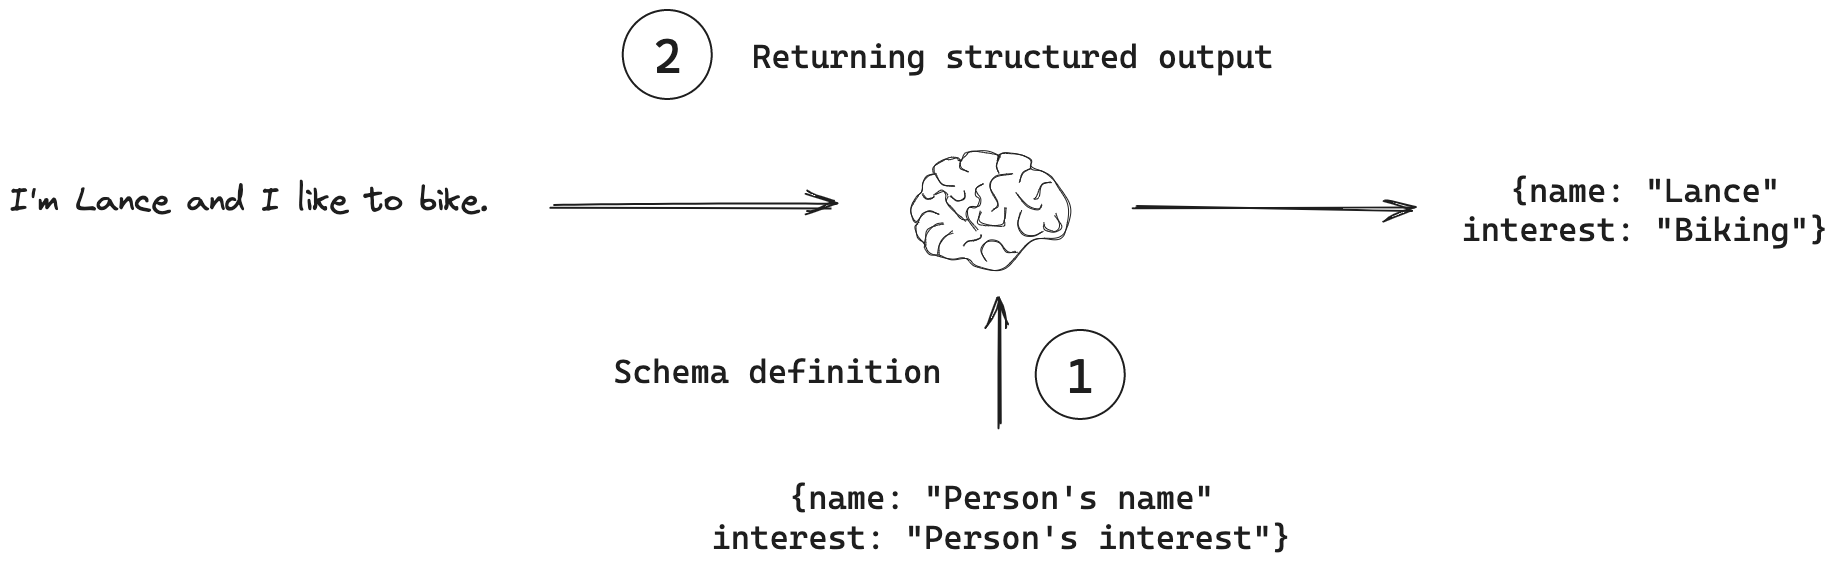
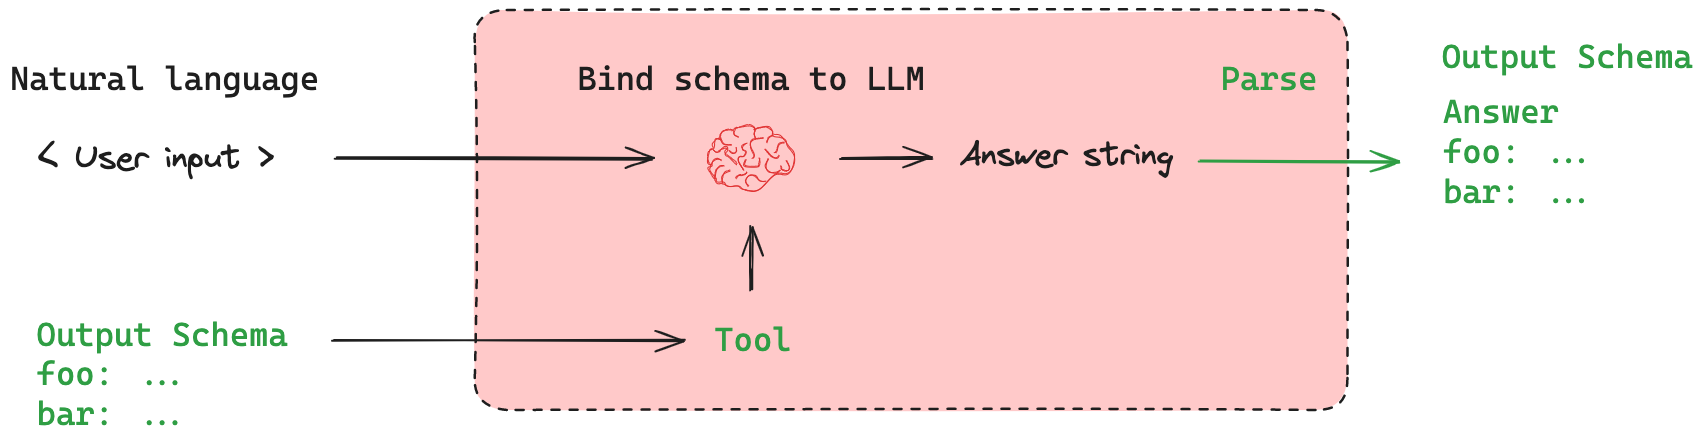

In [38]:
from dotenv import load_dotenv
load_dotenv("/home/sergii/.env")

from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage
from langchain_core.pydantic_v1 import BaseModel

In [2]:
model = ChatOllama(model="llama3.1", verbose=True)

In [4]:
class Output(BaseModel):
    feelings: str

model.with_structured_output(Output).invoke([HumanMessage("Hello, how are you?")])

Output(feelings='I am doing well, thank you for asking')

In [12]:
model.with_structured_output({
  "title": "express your feelings",
  "mood": "what is your mood?",
}).invoke([HumanMessage("Hello, how are you?")])

{'arg1': 'Hello, how are you?'}

In [26]:
model.with_structured_output({
  # "title": "Always use this format to structure your response to the user.",
  # "title": "Respond to the user's original question and then ask a followup question",
  "title": "use the answer and followup_question keys for the answer of users original question and a followup question",
  "answer": "The answer to the user's question",
  "followup_question": "A followup question the user could ask"
}).invoke([HumanMessage("Hello, how are you?")])

{'answer': "I am an assistant and I don't have feelings or emotions. How can I assist you today?",
 'followup_question': 'What would you like to talk about?'}

In [18]:
from pydantic import BaseModel, Field
class ResponseFormatter(BaseModel):
    """Always use this tool to structure your response to the user."""
    answer: str = Field(description="The answer to the user's question")
    followup_question: str = Field(description="A followup question the user could ask")


model.with_structured_output(ResponseFormatter).invoke([HumanMessage("Hello, how are you?")])

ResponseFormatter(answer='I am functioning properly, thank you for asking!', followup_question='How can I assist you today?')

In [29]:
tooled_model = model.bind_tools([ResponseFormatter])
tooled_response = tooled_model.invoke([HumanMessage("Hello, how are you?")])
tooled_response

AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-18T05:34:45.16495525Z', 'done': True, 'done_reason': 'stop', 'total_duration': 450493683, 'load_duration': 23346158, 'prompt_eval_count': 195, 'prompt_eval_duration': 10000000, 'eval_count': 56, 'eval_duration': 416000000, 'message': Message(role='assistant', content='', images=None, tool_calls=[ToolCall(function=Function(name='ResponseFormatter', arguments={'answer': 'I am a helpful assistant. I don’t have feelings but I am ready to assist with any questions or tasks you may have.', 'followup_question': 'What can I help you with today?'}))])}, id='run-09e34560-5668-4090-b4b3-7b0c236bc3be-0', tool_calls=[{'name': 'ResponseFormatter', 'args': {'answer': 'I am a helpful assistant. I don’t have feelings but I am ready to assist with any questions or tasks you may have.', 'followup_question': 'What can I help you with today?'}, 'id': 'c45d1a0c-ad44-47a3-8edb-b12451217399', 'type': 'to

In [31]:
ResponseFormatter.model_validate(tooled_response.tool_calls[0]["args"])

ResponseFormatter(answer='I am a helpful assistant. I don’t have feelings but I am ready to assist with any questions or tasks you may have.', followup_question='What can I help you with today?')

In [34]:
model = ChatOllama(model="llama3.1", model_kwargs={ "response_format": { "type": "json_object" }})
ai_msg = model.invoke("Return a JSON object with key 'random_ints' and a value of 10 random ints in [0-99]")
ai_msg

AIMessage(content='Here is the Python code to generate a JSON object with 10 random integers between 0 and 99:\n```python\nimport json\nimport random\n\ndef get_random_ints():\n    random_ints = random.sample(range(100), 10)\n    return {\'random_ints\': random_ints}\n\njson_obj = get_random_ints()\nprint(json.dumps(json_obj, indent=4))\n```\nThis code uses the `random` module to generate a list of 10 random integers between 0 and 99 using `random.sample`. The result is then converted into a JSON object using `json.dumps`.\n\nExample output:\n```json\n{\n    "random_ints": [\n        14,\n        73,\n        28,\n        41,\n        59,\n        38,\n        67,\n        82,\n        11,\n        46\n    ]\n}\n```\nYou can run this code to generate a new set of random integers each time you run it.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-12-18T05:39:52.090716377Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2868168403, 'load_dur

In [35]:
print(ai_msg.content)

Here is the Python code to generate a JSON object with 10 random integers between 0 and 99:
```python
import json
import random

def get_random_ints():
    random_ints = random.sample(range(100), 10)
    return {'random_ints': random_ints}

json_obj = get_random_ints()
print(json.dumps(json_obj, indent=4))
```
This code uses the `random` module to generate a list of 10 random integers between 0 and 99 using `random.sample`. The result is then converted into a JSON object using `json.dumps`.

Example output:
```json
{
    "random_ints": [
        14,
        73,
        28,
        41,
        59,
        38,
        67,
        82,
        11,
        46
    ]
}
```
You can run this code to generate a new set of random integers each time you run it.


In [39]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o", model_kwargs={ "response_format": { "type": "json_object" } })
ai_msg = model.invoke("Return a JSON object with key 'random_ints' and a value of 10 random ints in [0-99]")
print(ai_msg.content)


  {
    "random_ints": [34, 67, 12, 89, 45, 23, 78, 56, 90, 11]
  }


In [40]:
import json
json_object = json.loads(ai_msg.content)
{'random_ints': [23, 47, 89, 15, 34, 76, 58, 3, 62, 91]}

{'random_ints': [23, 47, 89, 15, 34, 76, 58, 3, 62, 91]}